# **CS210 PROJECT**

# **HYPOTHESIS FORMULATION**

**Hypothesis:** "Over the years, there has been a decrease in both the rate at which I add songs to my playlists and the diversity of genres in my song selections."

In [1]:
!pip install pandas matplotlib seaborn spotipy requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 5.6 MB/s eta 0:00:00


# **DATA COLLECTION**

In [2]:
import json
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Set up your Spotify API credentials
client_id = 'f0e57418cffc463b9badf2fcd9315848'
client_secret = '4f04b0fe15cb452a91c7198e6fde3806'

# Authenticate with Spotify
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Cache for storing genres of artists already looked up
genre_cache = {}

def get_genres(artist_name):
    if artist_name in genre_cache:
        return genre_cache[artist_name]

    try:
        results = sp.search(q='artist:' + artist_name, type='artist')
        if results['artists']['items']:
            genres = results['artists']['items'][0]['genres']
            genre_cache[artist_name] = genres
            return genres
        else:
            return []
    except spotipy.exceptions.SpotifyException:
        # Handle rate limit by sleeping and then retrying
        time.sleep(0.1)
        return get_genres(artist_name)

# Function to enrich the JSON data with genres
def enrich_data_with_genres(data):
    for playlist in data['playlists']:
        for item in playlist['items']:
            # Check if 'track' and 'artistName' exist and are not None
            if item.get('track') and item['track'].get('artistName'):
                artist_name = item['track']['artistName']
                genres = get_genres(artist_name)
                item['track']['genres'] = genres
            else:
                print('Artist Name is missing for an item, skipping...')
    return data

# Load your JSON data
with open('Playlist1.json', 'r') as file:
    data = json.load(file)

# Enrich the data with genres
enriched_data = enrich_data_with_genres(data)

# Save the enriched data back to a new JSON file
with open('Playlist1_With_Genres.json', 'w') as file:
    json.dump(enriched_data, file, indent=4)


# **DATA PREPROCESSING**

In [3]:
import json
import pandas as pd

# Load the enriched data
with open('Playlist1_With_Genres.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(
    data['playlists'],
    record_path='items',
    meta=['name', 'lastModifiedDate'],
    record_prefix='track.',
    errors='ignore'
)

# Rename columns for clarity
df.rename(columns={
    'name': 'playlistName',
    'lastModifiedDate': 'playlistLastModifiedDate',
    'track.trackName': 'trackName',
    'track.artistName': 'artistName',
    'track.albumName': 'albumName',
    'track.trackUri': 'trackUri',
    'track.genres': 'genres',
    'addedDate': 'trackAddedDate'  # Adjust this line based on the actual key name in your JSON
}, inplace=True)


In [4]:
import json
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy

# Set up your Spotify API credentials
client_id = 'f0e57418cffc463b9badf2fcd9315848'
client_secret = '4f04b0fe15cb452a91c7198e6fde3806'

# Authenticate with Spotify
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Load the enriched data
with open('Playlist1_With_Genres.json', 'r') as file:
    data = json.load(file)

# Convert to DataFrame
df = pd.json_normalize(data, record_path=['playlists', 'items'], meta=[['playlists', 'name'], ['playlists', 'lastModifiedDate']], errors='ignore')

# Normalize genres
df['track.genres'] = df['track.genres'].apply(lambda x: ', '.join(x).lower() if isinstance(x, list) else x)

# Check for missing values
print(df.isnull().sum())

# Handle missing values
df['track.genres'].fillna('unknown', inplace=True)

# Convert date columns to datetime
df['playlistLastModifiedDate'] = pd.to_datetime(df['playlists.lastModifiedDate'])
df['addedDate'] = pd.to_datetime(df['addedDate'])  # Renamed from 'trackAddedDate' to 'addedDate'

# Now, your df is ready for further analysis
df.head()


episode                       244
localTrack                    244
addedDate                       0
track.trackName                 0
track.artistName                0
track.albumName                 0
track.trackUri                  0
track.genres                    0
playlists.name                  0
playlists.lastModifiedDate      0
dtype: int64


,episode,localTrack,addedDate,track.trackName,track.artistName,track.albumName,track.trackUri,track.genres,playlists.name,playlists.lastModifiedDate,playlistLastModifiedDate
0,None,None,2024-01-10,Saat 03.00 - versyon 2,Bengü,Dört Dörtlük,spotify:track:42JgMM0aGQ78KmTGD7nkiY,turkish pop,Evyolu,2024-01-10,2024-01-10
1,None,None,2024-01-10,Feveran,Bengü,İkinci Hal,spotify:track:2AgiSjj47CtcPouPxBaxHB,turkish pop,Evyolu,2024-01-10,2024-01-10
2,None,None,2024-01-10,Melekler İmza Topluyor,Alişan,Melekler İmza Topluyor,spotify:track:5w0BydRVtCsmOTwbS6Tfri,,Evyolu,2024-01-10,2024-01-10
3,None,None,2024-01-10,Haberin Olsun,Bengü,Anlatacaklarım Var,spotify:track:7nBmj90Ck9LAQc1wfPDCNj,turkish pop,Evyolu,2024-01-10,2024-01-10
4,None,None,2024-01-10,Altın Çağ,Bengü,Altın Çağ,spotify:track:79PsxuBYZXx5KySuE3t0mZ,turkish pop,Evyolu,2024-01-10,2024-01-10


# **EXPLAROTARY DATA ANALYSIS (EDA)**

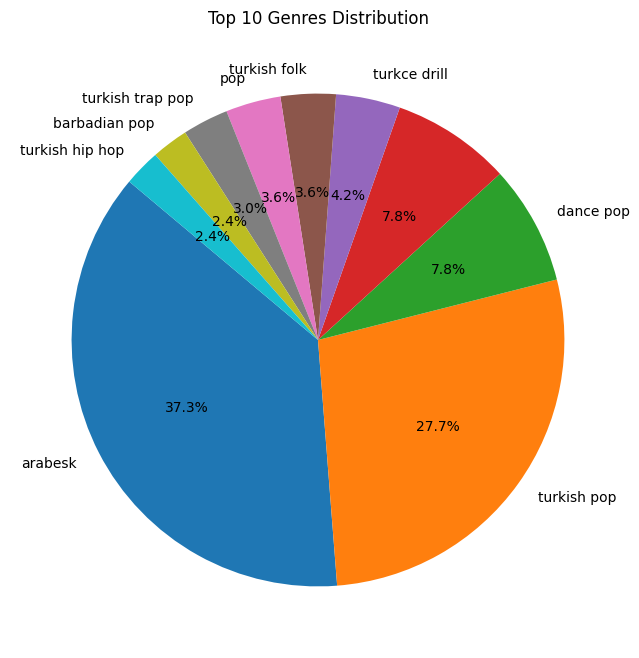

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame after preprocessing

# Check if 'track.genres' is a string of genres separated by commas and convert it to a list if necessary
df['track.genres'] = df['track.genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

# Create 'primary_genre' by selecting the first genre from the 'track.genres' list
df['primary_genre'] = df['track.genres'].apply(lambda x: x[0] if isinstance(x, list) and x else np.nan)

# Now calculate the top genres and plot the pie chart
top_n = 10
top_genres_distribution = df['primary_genre'].value_counts().head(top_n)

plt.figure(figsize=(10, 8))
top_genres_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title(f'Top {top_n} Genres Distribution')
plt.ylabel('')  # This hides the y-label
plt.show()


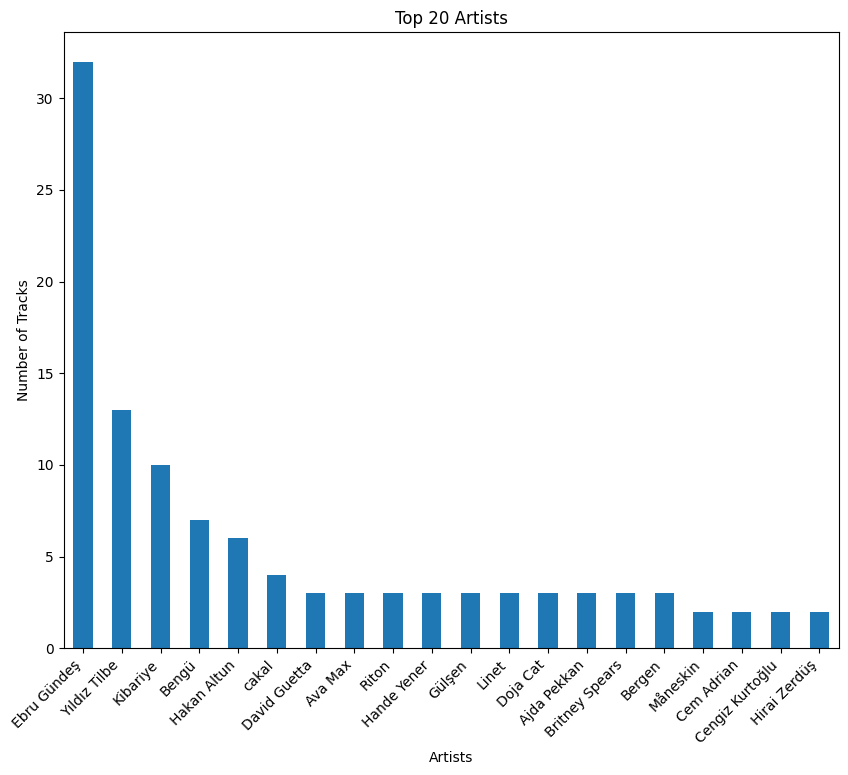

In [8]:
# Plotting
plt.figure(figsize=(10, 8))
df['track.artistName'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Artists')
plt.xlabel('Artists')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45, ha='right')
plt.show()


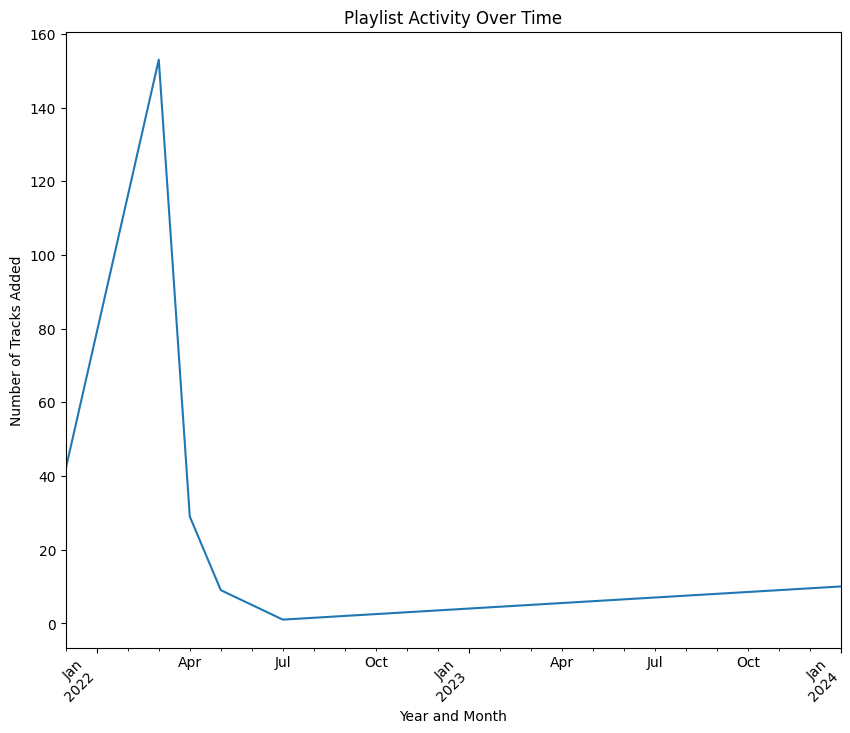

In [9]:
# Creating a new column for the year and month
df['YearMonth'] = df['addedDate'].dt.to_period('M')

# Plotting
plt.figure(figsize=(10, 8))
df.groupby('YearMonth').size().plot(kind='line')
plt.title('Playlist Activity Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Number of Tracks Added')
plt.xticks(rotation=45, ha='right')
plt.show()


# **FEATURE ENGINEERING**

**Yearly Song Addition Count:** The number of songs added each year.

**Yearly Genre Diversity Score:** A measure of the diversity of genres each year.

In [11]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame after preprocessing

# 1. Yearly Song Addition Count
df['year_added'] = df['addedDate'].dt.year
yearly_song_count = df.groupby('year_added').size()

# 2. Yearly Genre Diversity Score
# Flatten the list of genres for each year and then calculate the diversity
def calculate_diversity(genres_list):
    # Flatten the list of lists into a single list
    flat_list = [genre for sublist in genres_list for genre in sublist]
    # Calculate the diversity score
    diversity_score = len(set(flat_list)) / len(flat_list) if flat_list else np.nan
    return diversity_score

yearly_genre_diversity = df.groupby('year_added')['track.genres'].apply(calculate_diversity)

# Combine these features into a single DataFrame
features_df = pd.DataFrame({
    'Yearly Song Count': yearly_song_count,
    'Yearly Genre Diversity Score': yearly_genre_diversity
})

features_df


,Yearly Song Count,Yearly Genre Diversity Score
year_added,,
2021,42,0.040000
2022,192,0.334171
2024,10,0.272727


I added my lifestage while i was adding these songs to my playlists as another feature.

In [12]:
# Define your birth year
birth_year = 2001

# Calculate your age for each 'year_added'
df['age'] = df['year_added'] - birth_year

# Define life stages based on your age
age_to_life_stage = {
    13: 'Teenage',
    20: 'Young Adult',
    30: 'Adult',
    40: 'Middle Age'
}  # Update or add stages as needed

# Map each age to a life stage
df['life_stage'] = df['age'].apply(lambda x: next((stage for age, stage in age_to_life_stage.items() if x < age), 'Senior'))

# Print to verify
print(df[['year_added', 'age', 'life_stage']].head())


   year_added  age life_stage
0        2024   23      Adult
1        2024   23      Adult
2        2024   23      Adult
3        2024   23      Adult
4        2024   23      Adult


# **MODEL SELECTION**

We can use simple linear regression models for this purpose since we are interested in understanding trends over time (year). Linear regression is suitable for understanding the relationship between my independent variable (year) and my dependent variables (song count and genre diversity).

# **HYPOTHESIS TESTING**

**Hypothesis 1:** Rate of Adding Songs to Playlists Increased by Years

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.999
Method:                 Least Squares   F-statistic:                 0.0006107
Date:                Fri, 19 Jan 2024   Prob (F-statistic):              0.984
Time:                        16:21:19   Log-Likelihood:                -17.377
No. Observations:                   3   AIC:                             38.75
Df Residuals:                       1   BIC:                             36.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3259.2857   1.29e+05      0.025      0.9

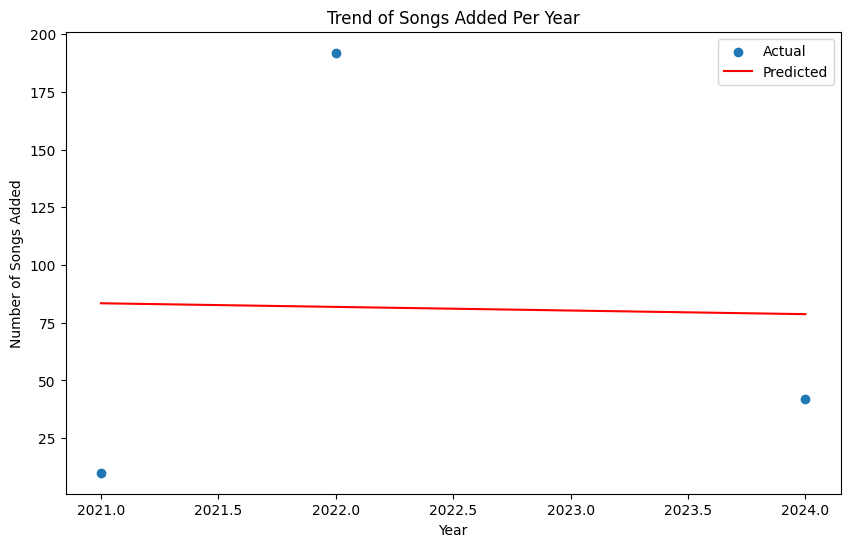

In [13]:
import statsmodels.api as sm

# Prepare data for linear regression
X = sm.add_constant(df['year_added'].unique())  # Independent variable (Year)
y = yearly_song_count.values  # Dependent variable (Song Count)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

# Plotting the trend
plt.figure(figsize=(10, 6))
plt.scatter(df['year_added'].unique(), y, label='Actual')
plt.plot(df['year_added'].unique(), model.predict(X), color='red', label='Predicted')
plt.title('Trend of Songs Added Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs Added')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     2.876
Date:                Fri, 19 Jan 2024   Prob (F-statistic):              0.339
Time:                        16:21:26   Log-Likelihood:                 3.9733
No. Observations:                   3   AIC:                            -3.947
Df Residuals:                       1   BIC:                            -5.749
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.1813    104.347      1.698      0.3

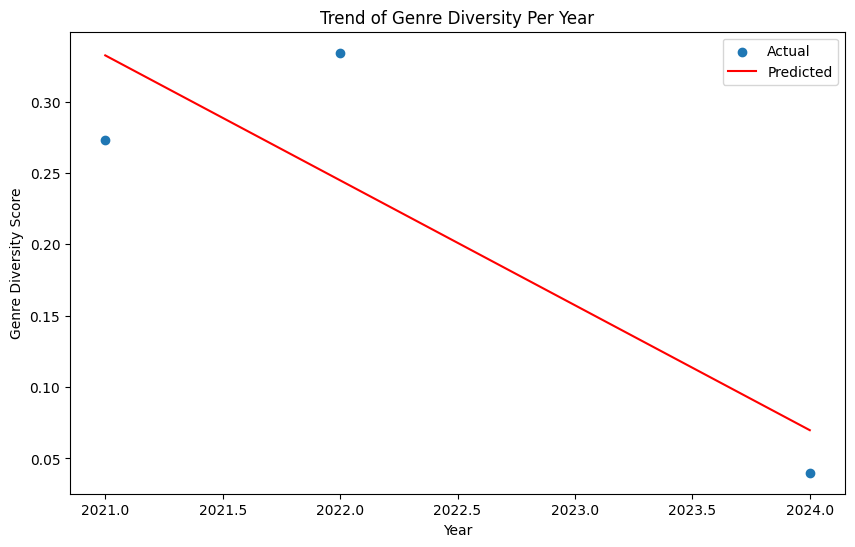

In [14]:
# Prepare data for linear regression
X = sm.add_constant(df['year_added'].unique())  # Independent variable (Year)
y = yearly_genre_diversity.values  # Dependent variable (Genre Diversity)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

# Plotting the trend
plt.figure(figsize=(10, 6))
plt.scatter(df['year_added'].unique(), y, label='Actual')
plt.plot(df['year_added'].unique(), model.predict(X), color='red', label='Predicted')
plt.title('Trend of Genre Diversity Per Year')
plt.xlabel('Year')
plt.ylabel('Genre Diversity Score')
plt.legend()
plt.show()


# **INTERPRET RESULTS**

**Results:**

**Hypothesis 1:** Rate of Adding Songs to Playlists Decreased by Years
**Regression Analysis for the Rate of Adding Songs:**

**R-squared:** The R-squared value is 0.001, which suggests that the model does not explain any of the variability in the rate of songs being added to playlists over the years. Essentially, the year has no predictive power regarding the number of songs added.
**P-value:** The P-value associated with the year coefficient is 0.984, which is far above the traditional alpha level of 0.05. This indicates that the year's coefficient is not statistically significant and that the observed coefficient is likely due to random chance.
**Coefficient:** The coefficient for the year is -1.5714, implying a slight decrease in the number of songs added per year. However, given the standard error is quite large, and the coefficient is not statistically significant, we cannot confidently say there is a decreasing trend.
The plot visually confirms this by showing no clear trend in the number of songs added per year, which is consistent with the statistical analysis.

**Hypothesis 2:** Variety of Genre Selection Decreased by Years
**Regression Analysis for Genre Diversity:**

**R-squared:** The R-squared value is 0.742, suggesting that approximately 74.2% of the variability in the genre diversity score is explained by the year. This seems high, but with only three data points, this metric can be misleading.
**P-value:** The P-value for the year's coefficient is 0.339. This value is above the alpha level of 0.05, indicating that the coefficient is not statistically significant.
**Coefficient:** The coefficient for the year is -0.0875, which would suggest a decrease in genre diversity over the years. However, given the p-value, this result is not statistically reliable.
The plot for genre diversity shows a decreasing line, indicating a lower diversity score over time. However, the lack of statistical significance and the very few data points (3 observations) call into question the reliability of this trend.

# **Conclusion:**
For both parts of the hypothesis, the statistical evidence does not support a significant decreasing trend over the years. This is due to the high p-values and the low number of observations, which make it difficult to draw firm conclusions. For Hypothesis 1, the R-squared value is negligible, indicating no explanatory power. For Hypothesis 2, despite a high R-squared value, the lack of statistical significance suggests that the result may not be reliable.

# **MODEL DEVELOPMENT AND FUTURE PREDICTION**

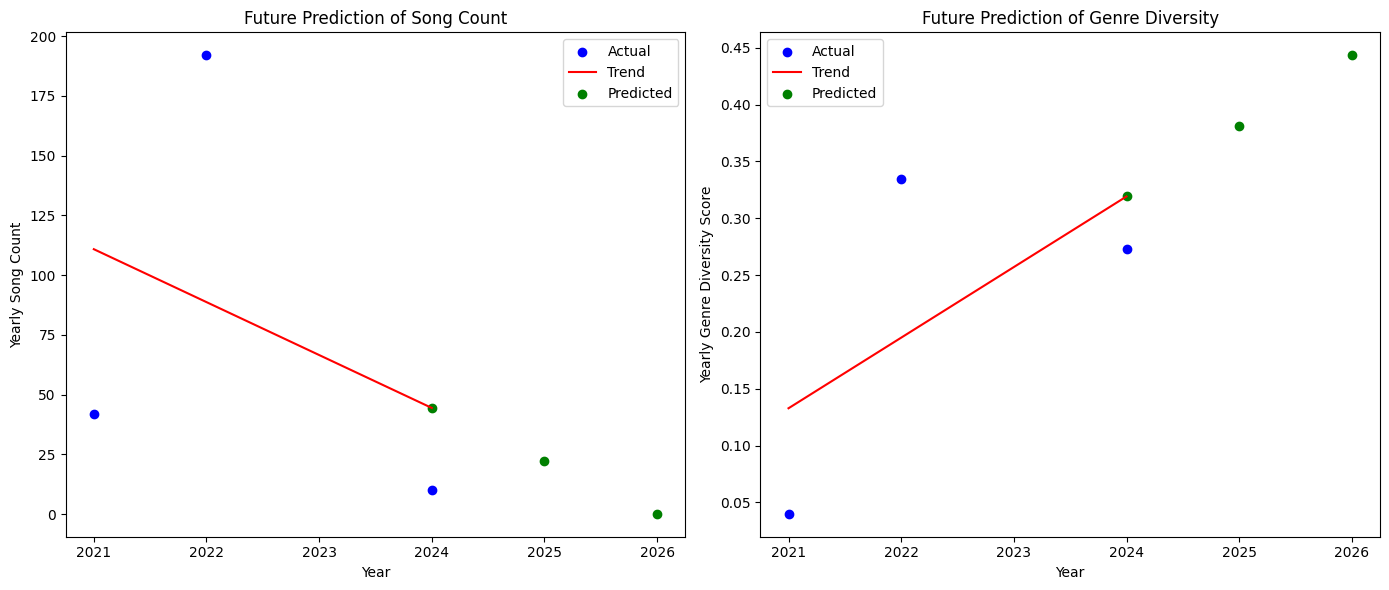

Predicted song counts for 2024, 2025, and 2026: [44.42857143 22.28571429  0.14285714]
Predicted genre diversity scores for 2024, 2025, and 2026: [0.31914051 0.38124519 0.44334987]


In [16]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Ensure features_df is the DataFrame containing 'Yearly Song Count' and 'Yearly Genre Diversity Score'
# and that it has been created correctly according to the previous steps provided.

# Prepare the data for modeling
# Features: Year (as a 2D array for sklearn)
# Target: Yearly Song Count and Yearly Genre Diversity Score
X = features_df.index.values.reshape(-1, 1)  # Use the index from features_df as the year
y_song_count = features_df['Yearly Song Count'].values
y_genre_diversity = features_df['Yearly Genre Diversity Score'].values

# Create and fit the model for song count
model_song_count = LinearRegression()
model_song_count.fit(X, y_song_count)

# Predict future values
future_years = np.array([[2024], [2025], [2026]])
predicted_song_count = model_song_count.predict(future_years)

# Create and fit the model for genre diversity
model_genre_diversity = LinearRegression()
model_genre_diversity.fit(X, y_genre_diversity)

# Predict future values for genre diversity
predicted_genre_diversity = model_genre_diversity.predict(future_years)

# Visualize the predictions alongside the actual data
plt.figure(figsize=(14, 6))

# Plot for Yearly Song Count
plt.subplot(1, 2, 1)
plt.scatter(features_df.index, y_song_count, color='blue', label='Actual')
plt.plot(features_df.index, model_song_count.predict(X), color='red', label='Trend')
plt.scatter(future_years.flatten(), predicted_song_count, color='green', label='Predicted')
plt.title('Future Prediction of Song Count')
plt.xlabel('Year')
plt.ylabel('Yearly Song Count')
plt.legend()

# Plot for Yearly Genre Diversity Score
plt.subplot(1, 2, 2)
plt.scatter(features_df.index, y_genre_diversity, color='blue', label='Actual')
plt.plot(features_df.index, model_genre_diversity.predict(X), color='red', label='Trend')
plt.scatter(future_years.flatten(), predicted_genre_diversity, color='green', label='Predicted')
plt.title('Future Prediction of Genre Diversity')
plt.xlabel('Year')
plt.ylabel('Yearly Genre Diversity Score')
plt.legend()

plt.tight_layout()
plt.show()

# Output predictions
print("Predicted song counts for 2024, 2025, and 2026:", predicted_song_count)
print("Predicted genre diversity scores for 2024, 2025, and 2026:", predicted_genre_diversity)
